<a href="https://colab.research.google.com/github/aagarwal17/datasci-207-arun/blob/main/05_Multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional notes:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding;
* You may import any libraries you need to complete the assignment. However, you must implement the model using TensorFlow (do not use PyTorch);
* Follow the same steps/idea as in Assignment 4; the difference here is that you extend a logistic model to more than two classes;
* <span style="color:chocolate"> Focus on the execution of the task rather than model performance </span> (this is how the TA will grade your work);
* Even though the prediction performance for your chosen outcome is low, it doesn't necessarily mean there is something wrong with your implementation. It could also be that the data is not supportive enough for your prediction task... again, focus on the learning opportunity and not the numbers you get;
* Your instructional team has extensive experience developing and running ML models. Often, we encounter situations where a model doesn't perform well on a predictive task. This can happen due to the nature of the data or the need for significant tweaking of variables to achieve good results;
* Do not spend significantly more time on this task than you did on Assignment 4, unless you wish to experiment and learn more.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task.


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [1]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [2]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters

# feel free to import other libraries as needed

import warnings
warnings.filterwarnings('ignore')

### Define functions

In [3]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )

    return df

In [4]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15

    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [5]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [6]:
# YOUR CODE HERE
# 1:
num_rows, num_cols = df.shape
print(f"Number of columns: {num_cols}")

# 2:
print(f"Number of rows: {num_rows}\n")

# 3:
print("Column names:")
print(df.columns.tolist(), "\n")

# 4:
print("Number of unique values per column:")
print(df.nunique(), "\n")

# 5:
print("Unique cocoa_percent values:")
print(sorted(df['cocoa_percent'].unique()))

Number of columns: 9
Number of rows: 1795

Column names:
['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin'] 

Number of unique values per column:
maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64 

Unique cocoa_percent values:
[42.0, 46.0, 50.0, 53.0, 55.0, 56.0, 57.0, 58.0, 60.0, 60.5, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 72.5, 73.0, 73.5, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 99.0, 100.0]


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here:

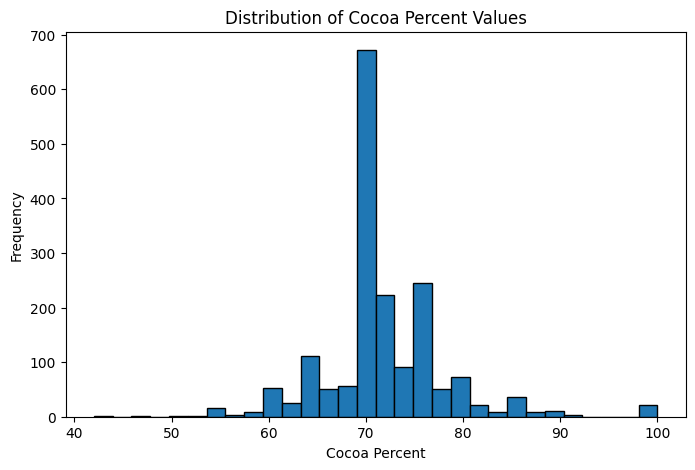

Chosen bins: [ 42.  66.  79. 100.]
Distribution of cocoa categories:
cocoa_category
1    1368
0     244
2     183
Name: count, dtype: int64


In [7]:
# YOUR CODE HERE

# I will predict cocoa_percent:

# Plotting to see cocoa_percent distribution
plt.figure(figsize=(8, 5))
plt.hist(df['cocoa_percent'], bins=30, edgecolor='black')
plt.xlabel("Cocoa Percent")
plt.ylabel("Frequency")
plt.title("Distribution of Cocoa Percent Values")
plt.show()

def categorize_cocoa_percent(df, num_bins = 3):
    sorted_percent = np.sort(df['cocoa_percent'].unique())
    bins = np.interp(np.linspace(0, len(sorted_percent), num_bins + 1), np.arange(len(sorted_percent)), sorted_percent)
    print(f"Chosen bins: {bins}")
    df['cocoa_category'] = pd.cut(df['cocoa_percent'], bins=bins, labels=list(range(num_bins)), include_lowest=True)
    return df
df = categorize_cocoa_percent(df)

print("Distribution of cocoa categories:")
print(df['cocoa_category'].value_counts())


---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

### Data Cleaning

In [8]:
def clean_broad_origin(df):
    replacements = {
        "nacional": "Peru",
        "Pangoa": "Peru",
        "Mex": "Mexico",
        "Martinique": "France",
        "Haw.": "Hawaii",
        "Guat.": "Guatemala",
        "Gre.": "Grenada",
        "Bali": "Indonesia",
        "Brasil": "Brazil",
        "C. Am.": "Central and S. America",
        "South America": "Central and S. America",
        "West Africa": "Africa"
    }
    def replace_origins(origin_string):
        if pd.isna(origin_string):
          return origin_string
        origins = origin_string.split(",")
        new_origins = []
        for origin in origins:
            if origin in replacements:
                new_origins.append(replacements[origin])
            else:
                new_origins.append(origin)
        return ", ".join(new_origins)
    df['broad_origin'] = df['broad_origin'].apply(replace_origins)
    return df

df = clean_broad_origin(df)

In [9]:
def replace_broad_origin(bean_origin):
    if re.match(r"^D+[a-z]*.? ?R+[a-z]*.?", bean_origin):
        return "Dominican Republic"
    elif re.match(r"^V+en[a-z]*.?", bean_origin):
        return "Venezuela"
    elif re.match(r"^Mad[a-z]*.?", bean_origin):
        return "Madagascar"
    elif re.match(r"^N+ic[a-z]*.?", bean_origin):
        return "Nicaragua"
    elif re.match(r"^E+cu[a-z]*.?", bean_origin):
        return "Ecuador"
    elif re.match(r"^P+[a-z]? ?N[a-z]? ?G+[a-z]?.?", bean_origin):
        return "Papua New Guinea"
    elif re.match(r"^P+eru(.*)", bean_origin):
        return "Peru"
    elif re.match(r"^C+arribean(.*)", bean_origin):
        return "Carribean"
    elif re.match(r"^T+rinidad(.*)", bean_origin):
        return "Trinidad-Tobago"
    elif re.match(r"^T+obago(.*)", bean_origin):
        return "Trinidad-Tobago"
    elif re.match(r"^S+ao(.*)", bean_origin):
        return "Sao Tome-Principe"
    elif re.match(r"^P+rincipe(.*)", bean_origin):
        return "Sao Tome-Principe"
    else:
        return bean_origin

df['broad_origin'] = df['broad_origin'].astype(str).apply(lambda x: ', '.join([replace_broad_origin(origin.strip()) for origin in x.split(',')]))

In [10]:
def remove_duplicates_from_lists(df, column_name):
    df[column_name] = df[column_name].str.split(', ')
    df[column_name] = df[column_name].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
    df[column_name] = df[column_name].str.join(', ')
    return df
df = remove_duplicates_from_lists(df, 'broad_origin')

In [11]:
def unique_specific_origins(df):
    unique_origins = set()
    for origin in df['specific_origin'].dropna():
        origins = [o.strip() for o in origin.split(',')]
        for o in origins:
            unique_origins.add(o)
    return sorted(list(unique_origins))

unique_specific_origin_values = unique_specific_origins(df)
unique_specific_origin_values

['"El Guinacho"',
 '"Floral"',
 '"Fruity"',
 '"Love Bar"',
 '"Porcelana" 72hr c',
 '"Zarumilla"',
 '"heirloom"',
 '#151',
 '#174',
 '#176',
 '#203',
 '#204',
 '#205',
 '#206',
 '#209',
 '#210',
 '#211',
 '#212',
 '#213',
 '#214',
 '#215',
 '#216',
 '#217',
 '#218',
 '#219',
 '#220',
 '#221',
 '#222',
 '#223',
 '#224',
 '#225',
 '#226',
 '#227',
 '#228',
 '#229',
 '#230',
 "'Smoke Monster'",
 '01',
 '0C',
 '100',
 '100 percent',
 '100% criollo',
 '120hr c',
 '16',
 '16hr conche',
 '2',
 '2007',
 '2008',
 '2009',
 '2009 Hapa Nibby',
 '2010',
 '2011',
 '2012',
 '2013',
 '2013 Harvest',
 '2014',
 '2014 Harvest',
 '2015',
 '2015 H',
 '2015 Harvest',
 '2015 harvest',
 '2016',
 '2016 H',
 '20hr conche',
 '3 diff plantations',
 '3800',
 '4500',
 '48hr c',
 '5 bean blend',
 '5 plantations',
 '5 yr Anniversary Ed',
 '6',
 '603070',
 '60hr c',
 '62hr C',
 '70hr C',
 '96hr c',
 'A',
 'A case of the Xerces Blues',
 'ABOCFA Coop',
 'Abinao',
 'Abstract S w',
 'Acarigua',
 'Acopagro',
 'Acul',
 'Afri

Since we fill nans in broad origin with specific origin, the weird values in broad origin come from specific origin. We will eventually only keep top count countries.

In [12]:
def unique_broad_origins(df):
    unique_origins = set()
    for origin in df['broad_origin']:
        if pd.notna(origin):
            for val in origin.split(','):
                unique_origins.add(val.strip())
    return unique_origins

unique_values = unique_broad_origins(df)
unique_values

{'100 percent',
 '2014',
 '2015 H',
 '5 plantations',
 '5 yr Anniversary Ed',
 'Africa',
 'Africa meets Latina',
 'Amazonas',
 'Amazonas Frucht',
 'Andoa',
 'Australia',
 'Batch 2',
 'Belize',
 'Bittersweet',
 'Blend',
 'Blend No 1',
 'Blend No 49',
 'Blu',
 'Bolivia',
 'Brazil',
 'Brooklyn Blend',
 'Burma',
 'Cacao Nib Crunch',
 'Cameroon',
 'Campesino w',
 'Caraque',
 'Carre Amer',
 'Carre Grand Noir',
 'Carribean',
 'Central',
 'Central America',
 'Central and S. America',
 "Chef's Blend",
 'Colombia',
 'Complexite',
 'Congo',
 'Costa Rica',
 'Coucher du Soleil',
 'Cuba',
 'Dark',
 'Dominican Republic',
 'Downtown London',
 'Ecuador',
 'El Salvador',
 'Epique',
 'Excellence',
 'Extra Dark',
 'Fiji',
 'France',
 'Gabon',
 'Ghana',
 'Goddess Blend',
 'Grand Cru Blend No1',
 'Grand Cru blend',
 'Grenada',
 'Guatemala',
 'Haiti',
 'Hawaii',
 'Honduras',
 'House Blend',
 'Houseblend',
 'Ilblend',
 'India',
 'Indianer',
 'Indonesia',
 'Ivory Coast',
 'Jamaica',
 'Java',
 'Kendari',
 'Kerc

In [13]:
pip install country_list

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.5 MB/s eta 0:00:00


In [14]:
from country_list import countries_for_language
countries = dict(countries_for_language('en'))
# Produced this list manually as they are not included in country list
locations = ["Africa", "Amazonas", "Brasil", "Burma", "Caribbean", "Central America", "Congo", "Hawaii", "Ivory Coast", "Java", "Sao Tome", "South America", "St Lucia", "Tobago", "Trinidad", "West Africa"]

In [15]:
# For broad origin column, if the row value contains value in countries.values() or locations list, keep the value. Otherwise, change value to nan:
def clean_broad_origin(df, countries, locations):
    def process_origin(origin):
        if pd.isna(origin):
            return np.nan
        origin_parts = [part.strip() for part in origin.split(',')]
        for part in origin_parts:
            if part in countries.values() or part in locations:
                return origin
        return np.nan
    df['broad_origin'] = df['broad_origin'].apply(process_origin)
    return df
df = clean_broad_origin(df, countries, locations)
df.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,cocoa_category
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,NaN,0
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,1
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,1
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,1
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,1


In [16]:
df[['bean_origin_1', 'bean_origin_2', 'bean_origin_3', 'bean_origin_4', 'bean_origin_5']] = df['broad_origin'].str.split(',', expand=True)

In [17]:
# Clean and replace inconsistent values in all 'bean_origin_*' columns
def clean_bean_origin(bean_origin):
    if pd.isna(bean_origin):
        return bean_origin
    bean_origin = bean_origin.strip()
    return bean_origin

# Apply cleaning function to each 'bean_origin_*' column
for i in range(1, 6):
    df[f'bean_origin_{i}'] = df[f'bean_origin_{i}'].apply(clean_bean_origin)

# Separate rows where multiple values exist in each 'bean_origin_*' column
for i in range(1, 6):
    df = df.assign(**{f'bean_origin_{i}': df[f'bean_origin_{i}'].str.split('&')}).explode(f'bean_origin_{i}')

# Remove any leading or trailing spaces from each 'bean_origin_*' column
for i in range(1, 6):
    df[f'bean_origin_{i}'] = df[f'bean_origin_{i}'].str.strip()

In [18]:
# Replace None values in 'bean_origin_*' columns with np.nan
for i in range(1, 6):
    df[f'bean_origin_{i}'] = df[f'bean_origin_{i}'].replace('None', np.nan)

In [19]:
# check for unique values in bean type:
df['bean_type'].unique()

array(['Blend', 'Criollo', 'Trinitario', 'Forastero (Arriba)',
       'Forastero', 'Forastero (Nacional)', 'Criollo, Trinitario',
       'Criollo (Porcelana)', 'Trinitario (85% Criollo)',
       'Forastero (Catongo)', 'Forastero (Parazinho)', 'CCN51',
       'Criollo (Ocumare)', 'Nacional', 'Criollo (Ocumare 61)',
       'Criollo (Ocumare 77)', 'Criollo (Ocumare 67)', 'Criollo (Wild)',
       'Beniano', 'Amazon mix', 'Trinitario, Forastero',
       'Forastero (Arriba) ASS', 'Criollo, +', 'Amazon', 'Amazon, ICS',
       'EET', 'Blend-Forastero,Criollo', 'Trinitario (Scavina)',
       'Criollo, Forastero', 'Matina', 'Forastero(Arriba, CCN)',
       'Nacional (Arriba)', 'Forastero (Arriba) ASSS',
       'Forastero, Trinitario', 'Forastero (Amelonado)',
       'Trinitario, Nacional', 'Trinitario (Amelonado)',
       'Trinitario, TCGA', 'Criollo (Amarru)'], dtype=object)

In [20]:
# Features for 4 beans:
def check_bean(l, name):
    l = l.lower()
    if name in l:
        return 1
    return 0

df["criollo_bean"] = df.bean_type.dropna().apply(lambda l: check_bean(l, "criollo"))
df["forastero_bean"] = df.bean_type.dropna().apply(lambda l: check_bean(l, "forastero"))
df["trinitario_bean"] = df.bean_type.dropna().apply(lambda l: check_bean(l, "trinitario"))
df["amazon_bean"] = df.bean_type.dropna().apply(lambda l: check_bean(l, "amazon"))
df.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,cocoa_category,bean_origin_1,bean_origin_2,bean_origin_3,bean_origin_4,bean_origin_5,criollo_bean,forastero_bean,trinitario_bean,amazon_bean
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,1,Togo,None,None,None,None,0,0,0,0
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,1,Togo,None,None,None,None,0,0,0,0
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,1,Togo,None,None,None,None,0,0,0,0
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,1,Peru,None,None,None,None,0,0,0,0


In [21]:
# Features for number of beans and if it is blend or not:
df["num_beans"] = df.loc[:,["criollo_bean", "forastero_bean", "trinitario_bean", "amazon_bean"]].sum(axis=1)
blend_names = df.bean_type.dropna().apply(lambda l: np.where("blend" in l.lower(), 1, 0))
is_blend_idx = blend_names.loc[blend_names == 1].index.values
df["blend"] = 0
df.loc[(df.num_beans > 1) | (df.index.isin(is_blend_idx)), "blend"] = 1
df.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,cocoa_category,...,bean_origin_2,bean_origin_3,bean_origin_4,bean_origin_5,criollo_bean,forastero_bean,trinitario_bean,amazon_bean,num_beans,blend
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,NaN,0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,1
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,1,...,None,None,None,None,0,0,0,0,0,1
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,1,...,None,None,None,None,0,0,0,0,0,1
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,1,...,None,None,None,None,0,0,0,0,0,1
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,1,...,None,None,None,None,0,0,0,0,0,1


89


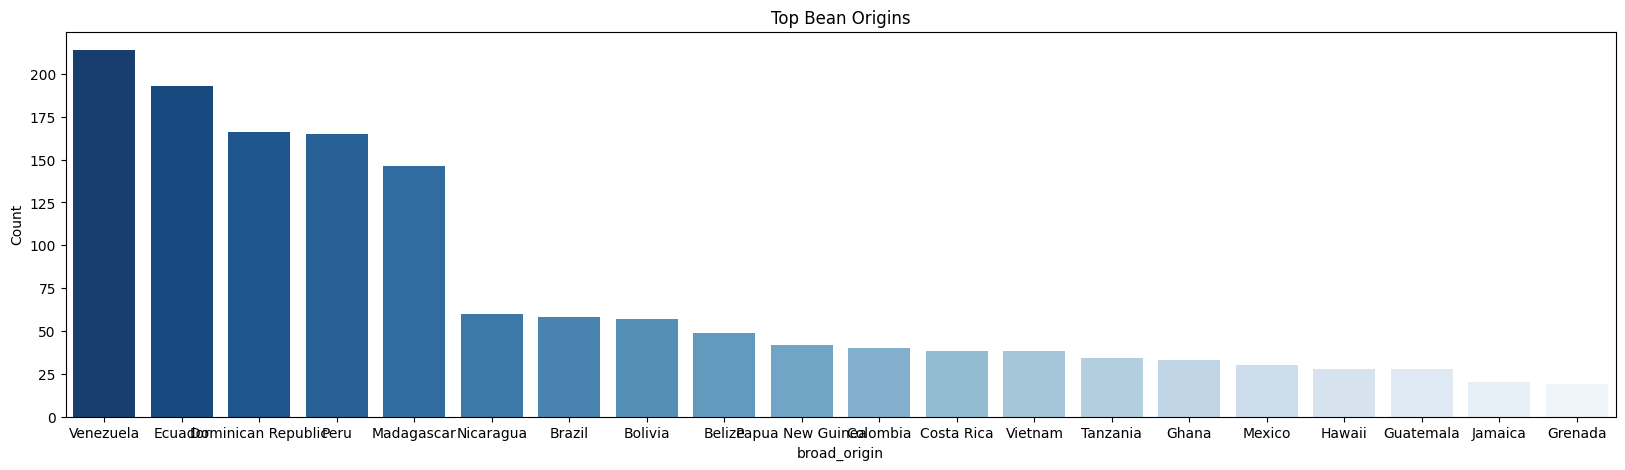

In [22]:
# Top Bean Origins
import seaborn as sns
print(len(df.broad_origin.unique()))
top_counts = df.broad_origin.value_counts().head(20)
sparse_counts = df.broad_origin.value_counts().tail(10)

plt.figure(figsize=(20,5))
sns.barplot(x=top_counts.index, y=top_counts.values, palette="Blues_r")
plt.title("Top Bean Origins")
plt.ylabel("Count");


In [23]:
sparse_counts

,count
broad_origin,
"Peru, SMartin",1
"Trinidad-Tobago, Madagascar, Venezuela",1
"Carribean, Jamaica, Trinidad-Tobago, Dominican Republic",1
"Ghana, Madagascar",1
"Peru, Ecuador, Nicaragua, Venezuela",1
"Ecuador, Madagascar",1
"Peru, Papua New Guinea, Guatemala, Dominican Republic, Madagascar",1
"Peru, Dominican Republic",1
"Madagascar, Dominican Republic",1


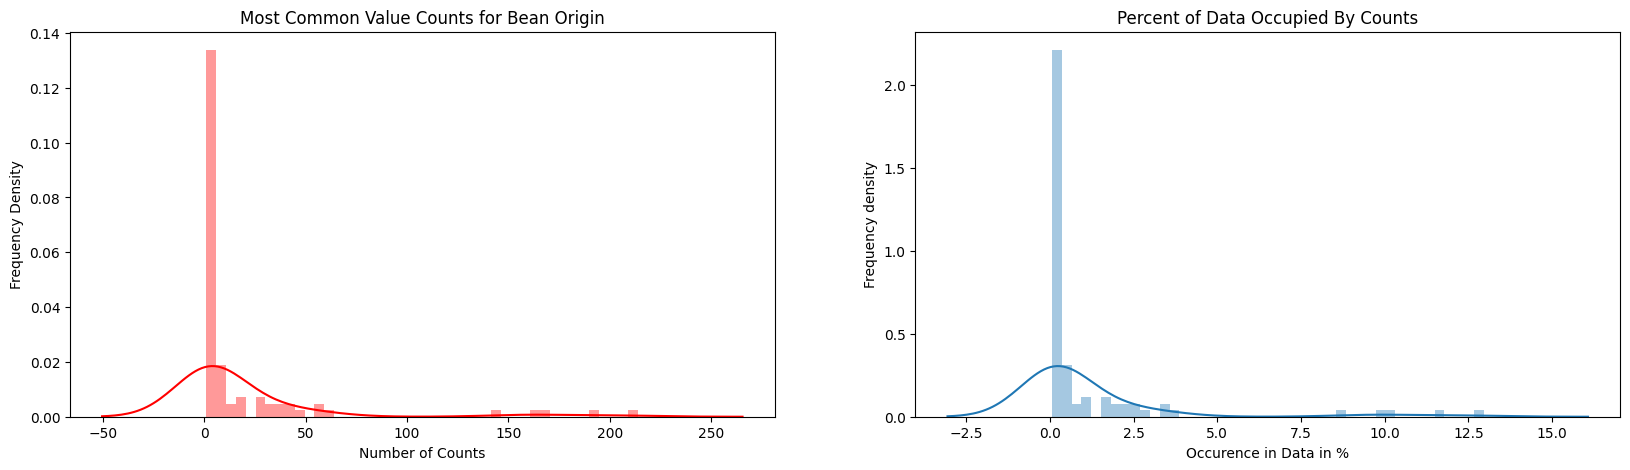

In [24]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(df.broad_origin.value_counts(), ax=ax[0], color="Red")
sns.distplot(df.broad_origin.value_counts() / df.broad_origin.count() * 100, ax=ax[1])
ax[0].set_xlabel("Number of Counts");
ax[0].set_ylabel("Frequency Density");
ax[0].set_title("Most Common Value Counts for Bean Origin")
ax[1].set_xlabel("Occurence in Data in %");
ax[1].set_ylabel("Frequency density");
ax[1].set_title("Percent of Data Occupied By Counts");

I should combine origins with only a few counts, or only consider top 20 origin countries. Only a few origins have counts greater than 50.

In [25]:
# New column for each country in top_counts. If broad_origin columns 1 through 5 contain that columns country, write 1. Otherwise 0
top_countries = df.broad_origin.value_counts().head(20).index
for country in top_countries:
    df[country] = 0
    for i in range(1, 6):
        df.loc[df[f'bean_origin_{i}'] == country, country] = 1
df.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,cocoa_category,...,Colombia,Costa Rica,Vietnam,Tanzania,Ghana,Mexico,Hawaii,Guatemala,Jamaica,Grenada
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,1,...,0,0,0,0,0,0,0,0,0,0
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,1,...,0,0,0,0,0,0,0,0,0,0
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,1,...,0,0,0,0,0,0,0,0,0,0
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,1,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Value counts for each of the 20 country columns
for country in top_countries:
  print(f"Value counts for {country}:")
  print(df[country].value_counts())
  print("-" * 20)

Value counts for Venezuela:
Venezuela
0    1567
1     228
Name: count, dtype: int64
--------------------
Value counts for Ecuador:
Ecuador
0    1588
1     207
Name: count, dtype: int64
--------------------
Value counts for Dominican Republic:
Dominican Republic
0    1618
1     177
Name: count, dtype: int64
--------------------
Value counts for Peru:
Peru
0    1619
1     176
Name: count, dtype: int64
--------------------
Value counts for Madagascar:
Madagascar
0    1638
1     157
Name: count, dtype: int64
--------------------
Value counts for Nicaragua:
Nicaragua
0    1734
1      61
Name: count, dtype: int64
--------------------
Value counts for Brazil:
Brazil
0    1736
1      59
Name: count, dtype: int64
--------------------
Value counts for Bolivia:
Bolivia
0    1737
1      58
Name: count, dtype: int64
--------------------
Value counts for Belize:
Belize
0    1745
1      50
Name: count, dtype: int64
--------------------
Value counts for Papua New Guinea:
Papua New Guinea
0    1748
1  

In [27]:
def filter_dataframe(df, top_countries):
    mask = df.apply(lambda row: any(
        row[f'bean_origin_{i}'] in top_countries for i in range(1, 6)
    if pd.notna(row[f'bean_origin_{i}'])
        ), axis=1)
    return df[mask]

df_filtered = filter_dataframe(df, top_countries)
print(f"Shape of the DataFrame after filtering: {df_filtered.shape}")
print(f"Percentage of data retained: {df_filtered.shape[0]/df.shape[0]*100:.2f}%")

Shape of the DataFrame after filtering: (1498, 41)
Percentage of data retained: 83.45%


In [28]:
for column in df_filtered.columns:
    num_unique = df_filtered[column].nunique()
    print(f"Column '{column}': {num_unique} unique values")

Column 'maker': 375 unique values
Column 'specific_origin': 836 unique values
Column 'reference_number': 433 unique values
Column 'review_date': 12 unique values
Column 'cocoa_percent': 43 unique values
Column 'maker_location': 51 unique values
Column 'rating': 13 unique values
Column 'bean_type': 37 unique values
Column 'broad_origin': 56 unique values
Column 'cocoa_category': 3 unique values
Column 'bean_origin_1': 24 unique values
Column 'bean_origin_2': 14 unique values
Column 'bean_origin_3': 9 unique values
Column 'bean_origin_4': 4 unique values
Column 'bean_origin_5': 3 unique values
Column 'criollo_bean': 2 unique values
Column 'forastero_bean': 2 unique values
Column 'trinitario_bean': 2 unique values
Column 'amazon_bean': 2 unique values
Column 'num_beans': 3 unique values
Column 'blend': 2 unique values
Column 'Venezuela': 2 unique values
Column 'Ecuador': 2 unique values
Column 'Dominican Republic': 2 unique values
Column 'Peru': 2 unique values
Column 'Madagascar': 2 uniq

#### Identifying Features of Interest:
We are predicting cocoa percent using the category variable created, cocoa_category. We are interested in using the following as features: all of the individual bean origin country variables, blend, the 4 bean types, and the rating. Some of the features related to these were used to create the features we will be using, so we will not use them in our model. Also, the remaining originally provided features are cateogrical with too many distinct values, so as to not deal with the curse of dimensionality, we will not include them in our model. However, we will still examine them in the plotting phase.

In [29]:
# Features of interest:
features = top_countries.tolist() + ['blend', 'criollo_bean', 'forastero_bean', 'trinitario_bean', 'amazon_bean', 'rating']
df_selected = df_filtered[features + ['cocoa_category']].copy()
df_selected.head()

,Venezuela,Ecuador,Dominican Republic,Peru,Madagascar,Nicaragua,Brazil,Bolivia,Belize,Papua New Guinea,...,Guatemala,Jamaica,Grenada,blend,criollo_bean,forastero_bean,trinitario_bean,amazon_bean,rating,cocoa_category
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3.50,1
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2.75,1
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,3.50,1
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,3.75,1
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,4.00,1


In [30]:
# Shuffle the dataset:
indices = list(df_selected.index)
shuffled_indices = np.random.permutation(indices)
df_selected = df_selected.reindex(shuffled_indices)
print("Top 5 rows after shuffling:")
df_selected.head()

Top 5 rows after shuffling:


,Venezuela,Ecuador,Dominican Republic,Peru,Madagascar,Nicaragua,Brazil,Bolivia,Belize,Papua New Guinea,...,Guatemala,Jamaica,Grenada,blend,criollo_bean,forastero_bean,trinitario_bean,amazon_bean,rating,cocoa_category
926,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,2.25,1
825,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2.50,1
1588,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,3.25,1
852,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,3.75,1
1388,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3.75,1


In [31]:
# Create training, validation, and test datasets using a 60/20/20 split:
# Make X and Y dataframes:
X = df_selected.drop('cocoa_category', axis=1)
Y = df_selected['cocoa_category']

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=1234)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=1234)

print("Shapes of datasets:")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

Shapes of datasets:
X_train: (898, 26), Y_train: (898,)
X_val: (300, 26), Y_val: (300,)
X_test: (300, 26), Y_test: (300,)


In [32]:
# Standardizing columns:
from sklearn.preprocessing import MinMaxScaler

# Using MinMaxScaler because better for logistic regression to preserve order without distorting differences:
scaler_X = MinMaxScaler()
X_train['rating'] = scaler_X.fit_transform(X_train[['rating']])
X_val['rating'] = scaler_X.transform(X_val[['rating']])
X_test['rating'] = scaler_X.transform(X_test[['rating']])

---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

In [33]:
X_train.describe(include='all')


,Venezuela,Ecuador,Dominican Republic,Peru,Madagascar,Nicaragua,Brazil,Bolivia,Belize,Papua New Guinea,...,Hawaii,Guatemala,Jamaica,Grenada,blend,criollo_bean,forastero_bean,trinitario_bean,amazon_bean,rating
count,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00,...,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00,898.00
mean,0.14,0.14,0.11,0.11,0.11,0.04,0.04,0.04,0.03,0.03,...,0.03,0.02,0.01,0.01,0.53,0.14,0.11,0.27,0.00,0.55
std,0.35,0.35,0.32,0.32,0.32,0.20,0.19,0.21,0.18,0.16,...,0.16,0.13,0.11,0.12,0.50,0.35,0.31,0.44,0.06,0.12
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.56
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.62
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


The average rating that consumers are giving to chocolate bars is 0.55, or 3.1 on the scale of 1 to 5. The top countries that produces the cocoa beans are Venezuala and Ecuador. Trinitario beans are the most common, and amazon beans are the least common. About half of the rows are blends.

In [34]:
Y_train.describe(include='all')

,cocoa_category
count,898
unique,3
top,1
freq,693


Of the 898 values in the training target dataset, 691 have label 1. We expect this due to the labels we created at the beginning of the analysis, where the 70% cocoa category having the vast majority of the rows fell in the 1 category. We keep this in mind when evaluating the performance of our model later.

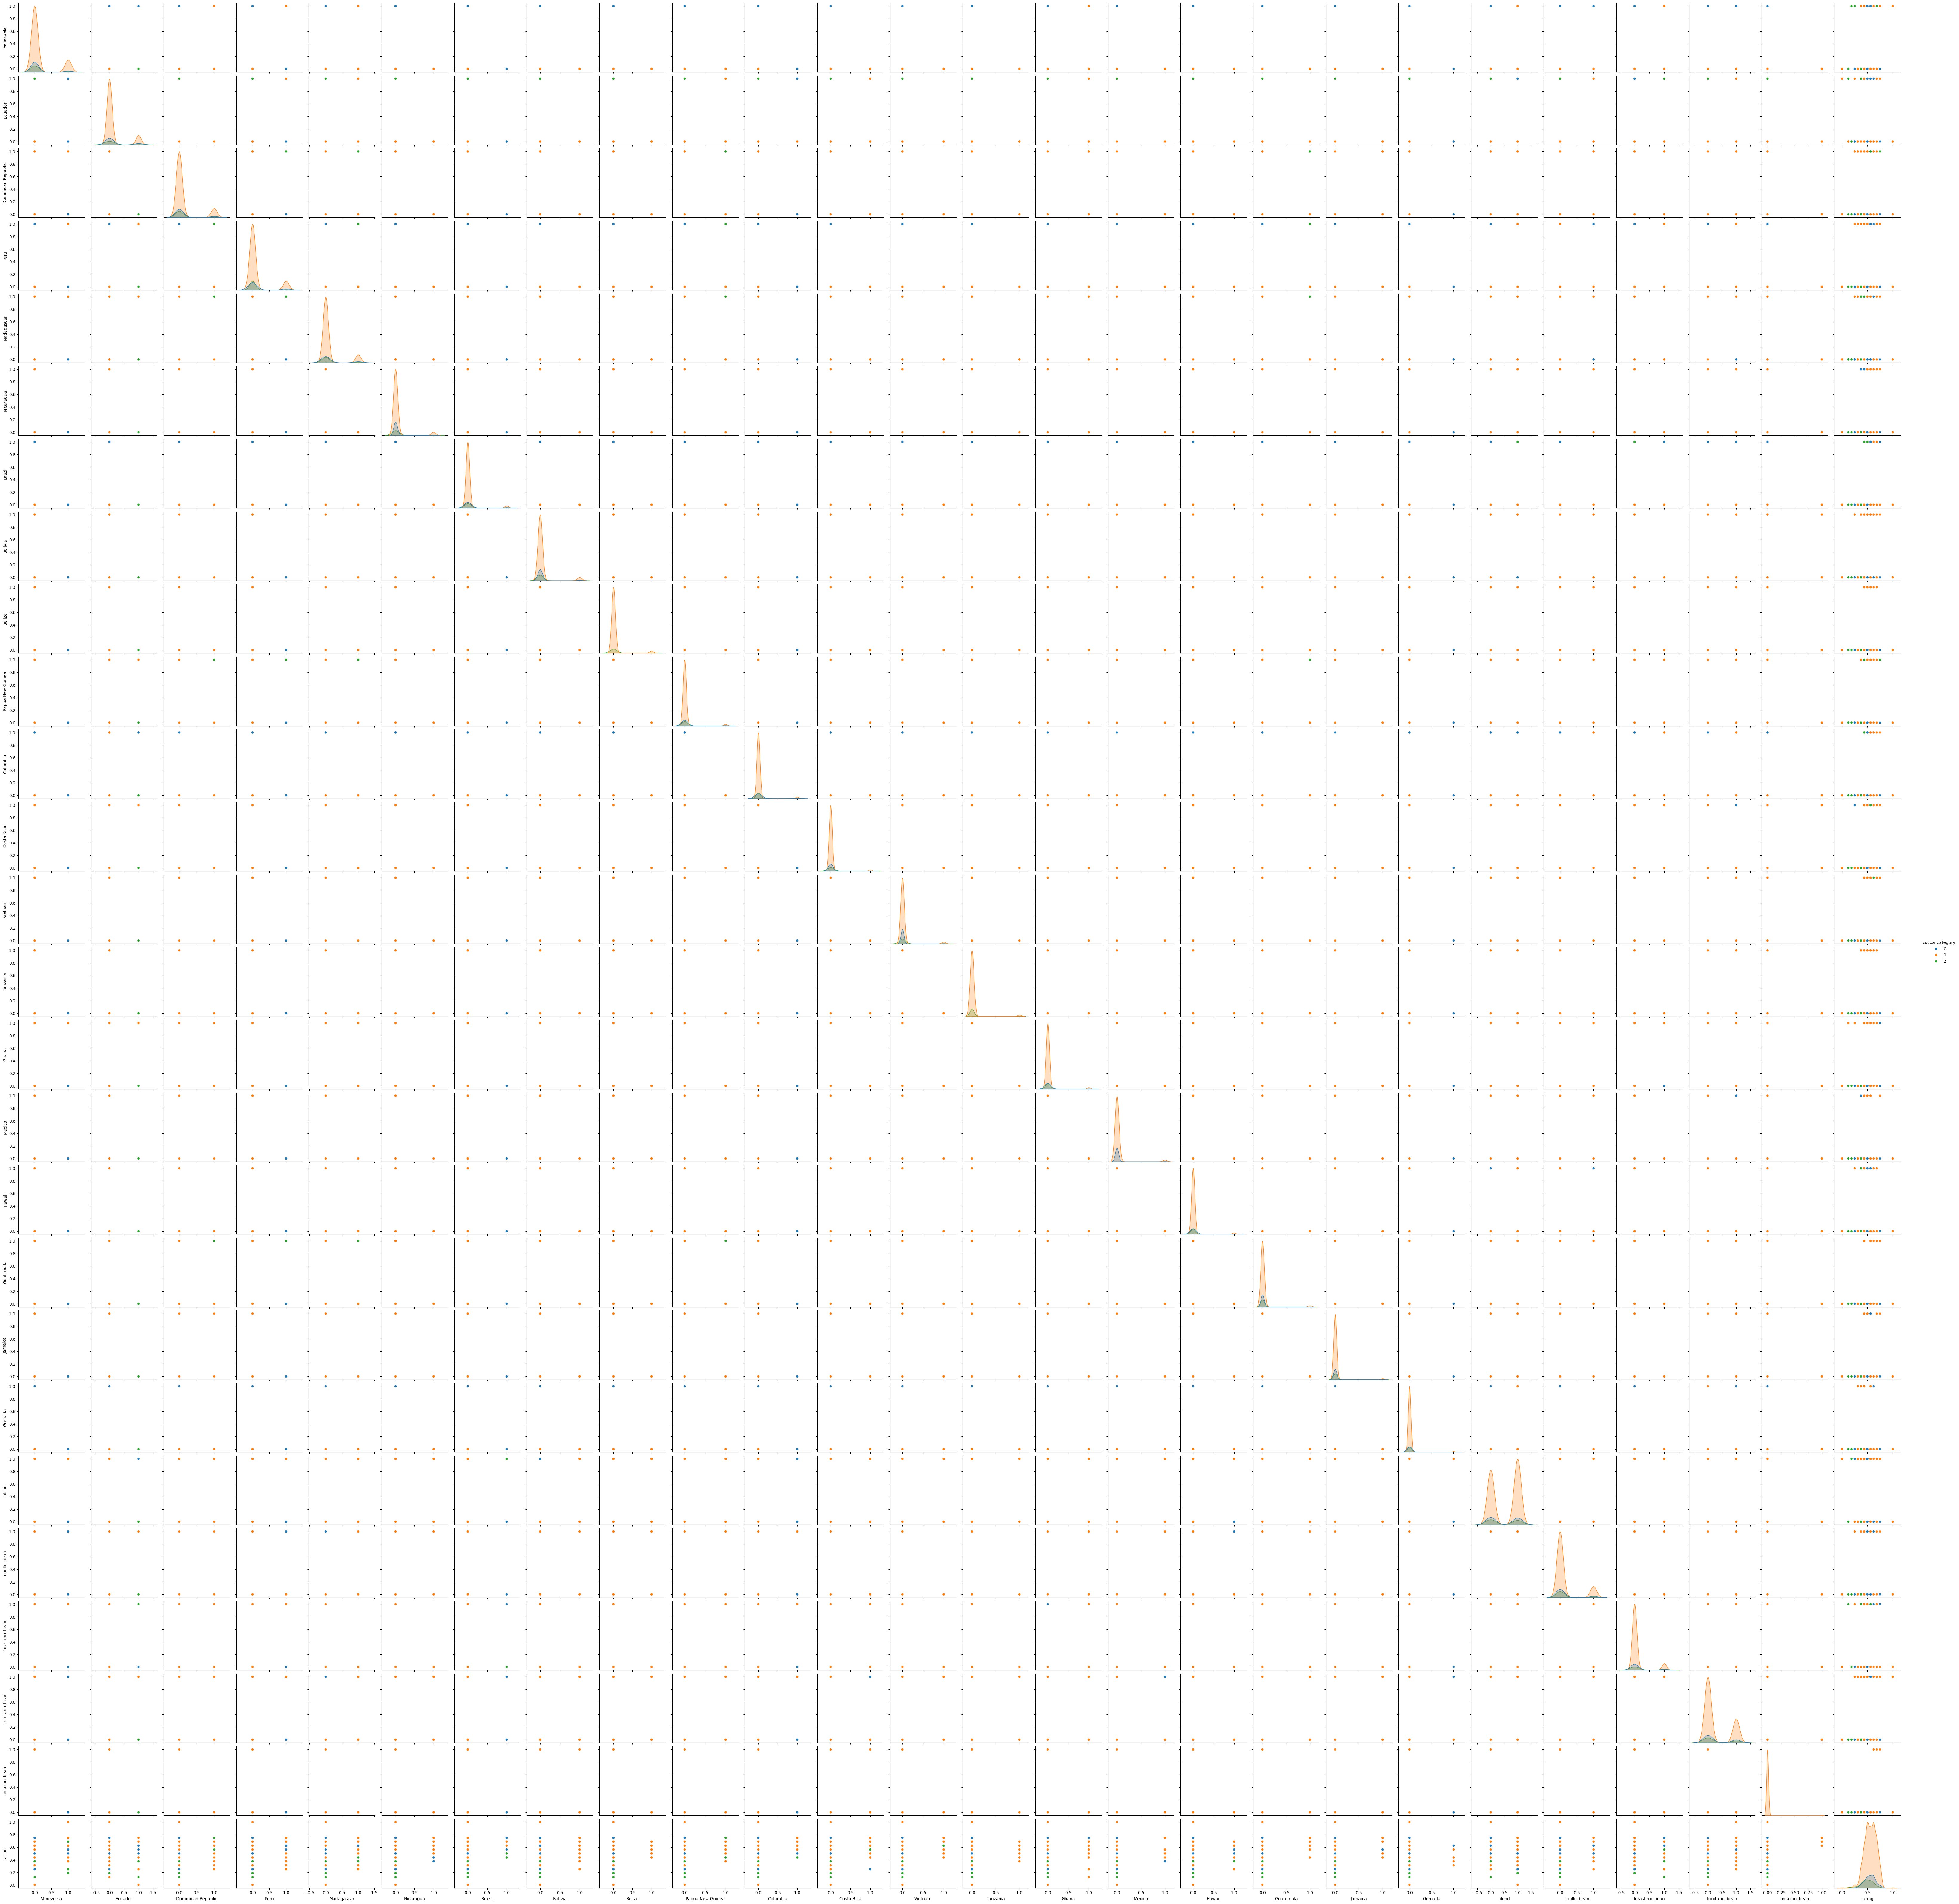

Feature distribution check:


In [35]:
# Note: this is not one of my 4 plots. I have just created it for my own reference. That is why I have not written a description for it.
sns.pairplot(pd.concat([X_train, Y_train], axis=1), hue='cocoa_category', diag_kind='kde')
plt.show()
print("Feature distribution check:")

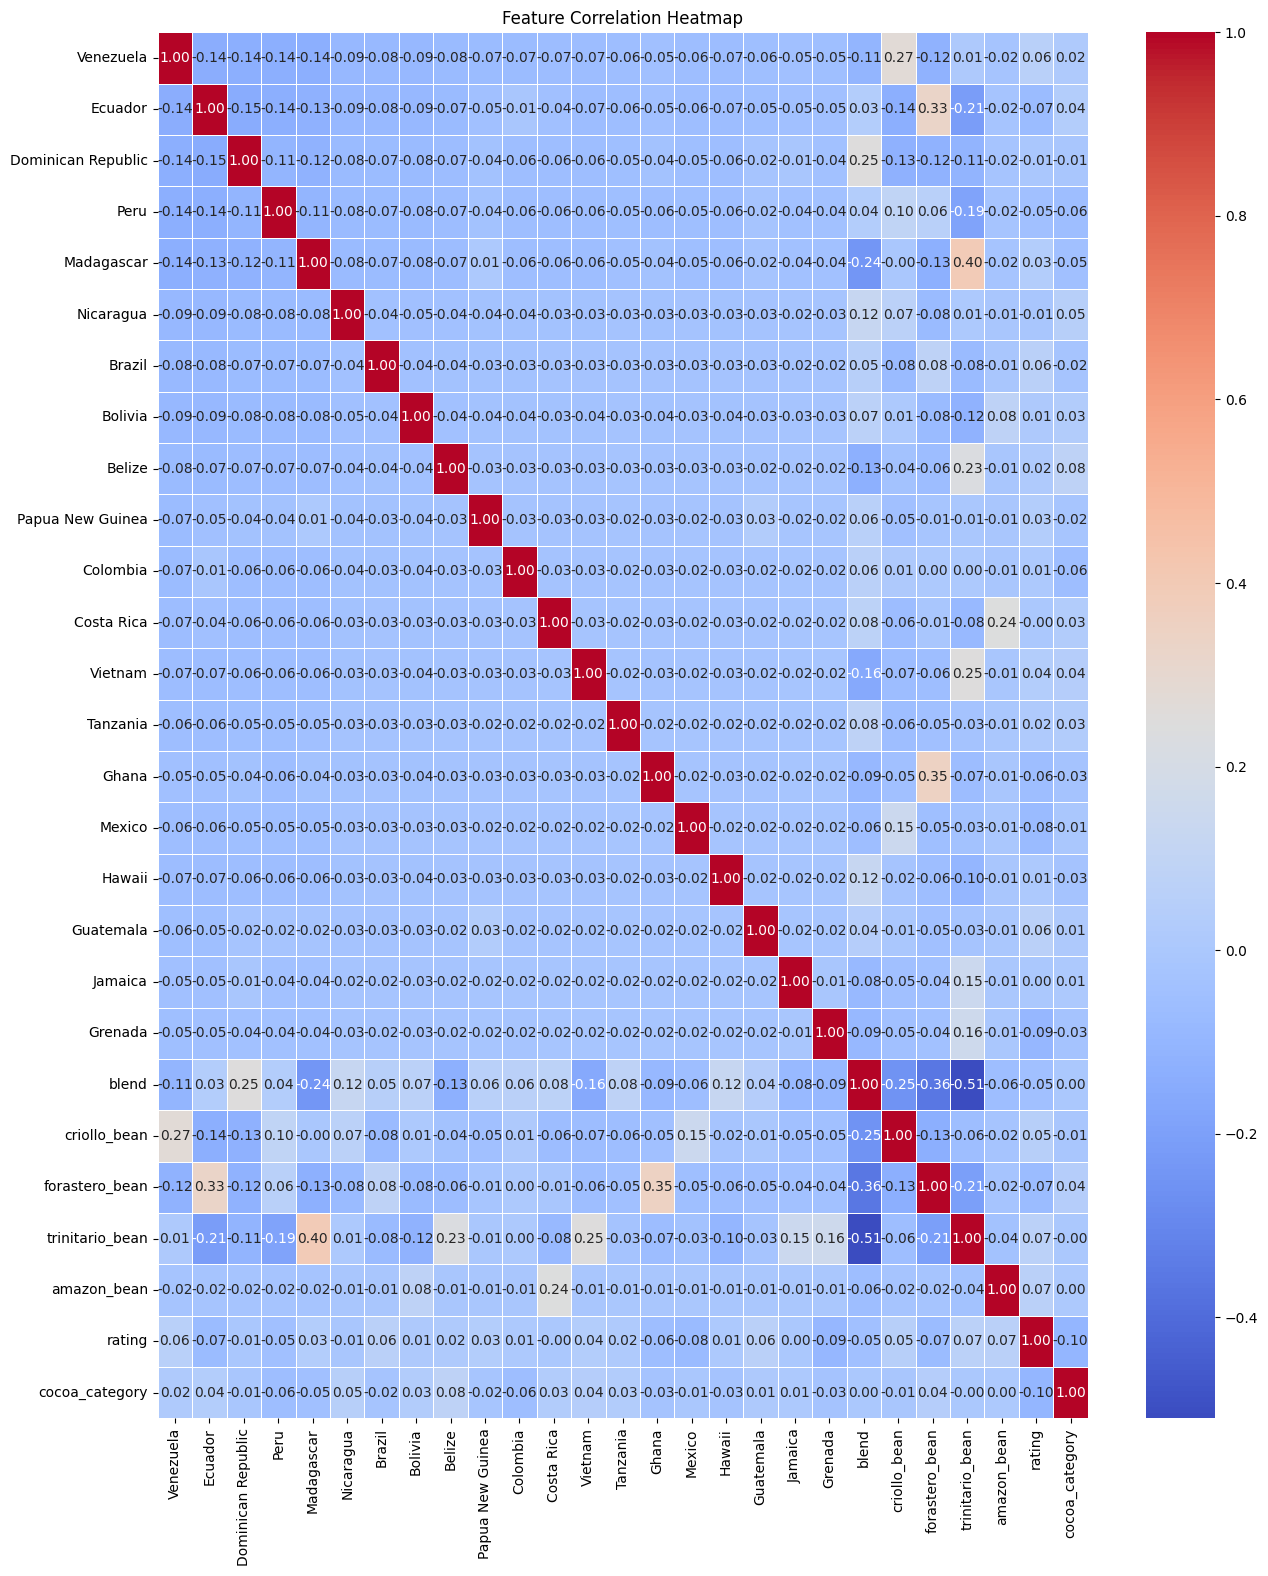

In [36]:
plt.figure(figsize=(15, 18))
corr_matrix = pd.concat([X_train, Y_train], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [37]:
abs_corr_matrix = corr_matrix.abs()
np.fill_diagonal(abs_corr_matrix.values, 0)
most_redundant_features = abs_corr_matrix.unstack().sort_values(ascending=False).index[0]
print("Most redundant features:", most_redundant_features)
least_useful_feature = abs_corr_matrix['cocoa_category'].drop('cocoa_category').idxmin()
print("Least useful feature for predicting cocoa category:", least_useful_feature)

Most redundant features: ('blend', 'trinitario_bean')
Least useful feature for predicting cocoa category: trinitario_bean


Based on the Correlation Matrix created, we found that most features have little correlation with each other and with cocoa_category. This might lead to poor performance of our model. The most redundant features are trinitario_bean and blend, as they have the highest correlation score of -0.52. These features are somewhat related contextually as it might suggest this bean is often included in a blend. The least useful feature for predicting cocoa category is the amazon bean as it had the lowest correlation score with the target variable, but this is most likely due to their being a small quantity of amazon beans being used in the rows of this data.

Fig 1: Count of Chocolate Bar Ratings


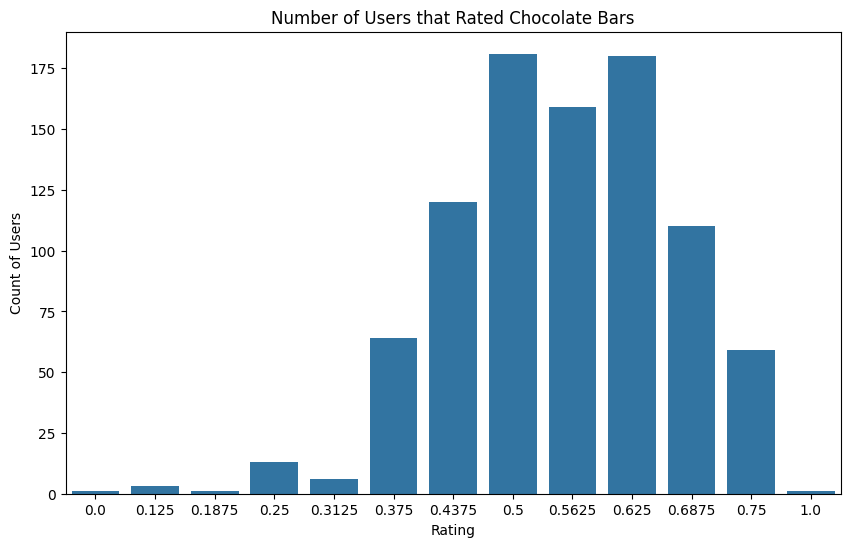

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=X_train)
plt.xlabel('Rating')
plt.ylabel('Count of Users')
plt.title('Number of Users that Rated Chocolate Bars')
print('Fig 1: Count of Chocolate Bar Ratings')

From the Count Plot above, we see that the distribution of ratings follows a mostly normal curve, with a high at 0.625. With our filtered data, we have a total of 1498 rows; however, only 898 are in the X_train dataset. The vast majority of ratings given fall between 0.4375 and 0.6875. Based on the scale provided, this means that most individuals are giving chocolate bars a rating a little bit more than satisfactory.

Text(0.5, 1.0, 'Count of Cocoa Categories in Chocolate Bars')

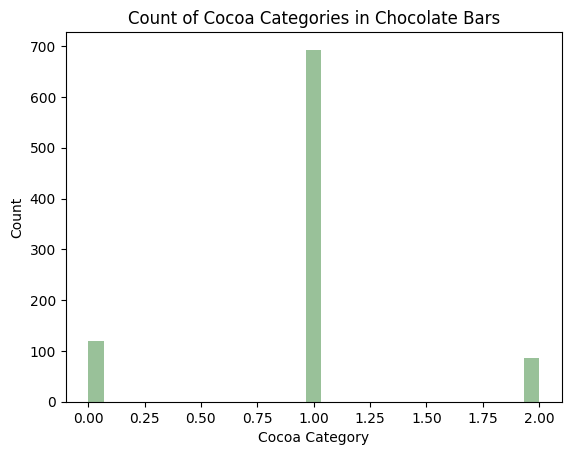

In [39]:
sns.distplot(a=Y_train, hist=True,kde=False,rug=False, color='darkgreen')
plt.xlabel('Cocoa Category')
plt.ylabel('Count')
plt.title('Count of Cocoa Categories in Chocolate Bars')

With this Count Plot, we now more clearly see the inequality in distribution of our target variable. Most chocolate bars are made with around 70 to 75% cocoa in the bar, which falls under the 1 classification. This class imblanace can and most likely will lead to poor model performance.

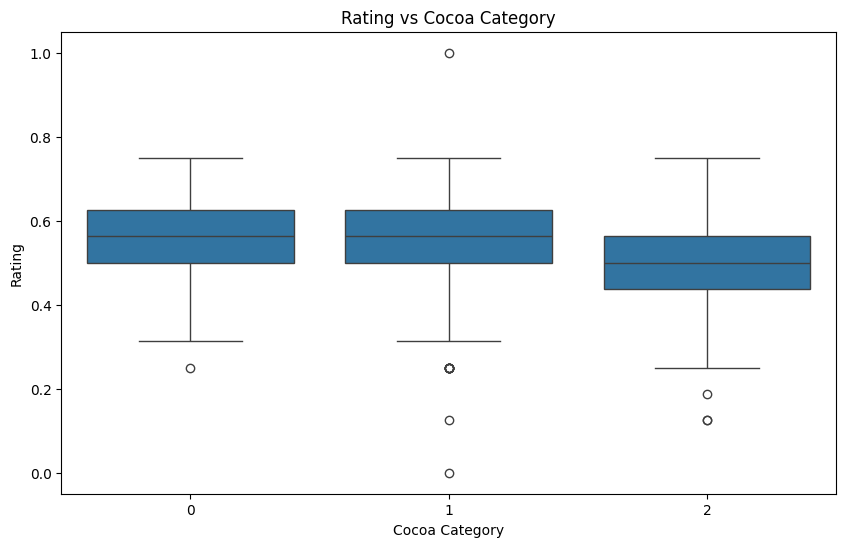

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=Y_train, y=X_train['rating'])
plt.xlabel("Cocoa Category")
plt.ylabel("Rating")
plt.title("Rating vs Cocoa Category")
plt.show()

The above boxplot allows us to visualize the distribution for each of the cocoa categories. We see that the 0 and 1 categories are almost identical, just with the 1 category having 2 more outliers, most likely due to it also containing the vast majority of the data. The median rating for these two categories is around 0.75, while it is a bit lower for the higher cocoa category (around 0.65). We see that the high (2) category also has a wider range of ratings than the low and medium category, suggesting people have more diverse takes on high cocoa content. There are people who give the highest rating no matter the cocoa content amount. The interquartile ranges for all 3 categories (while lower for the high category) have relatively the same size, covering about a 0.1 difference in rating span. All outliers exist in the lower rating values. The similarity between the 0 and 1 groups might make it hard to distinguish for the model.

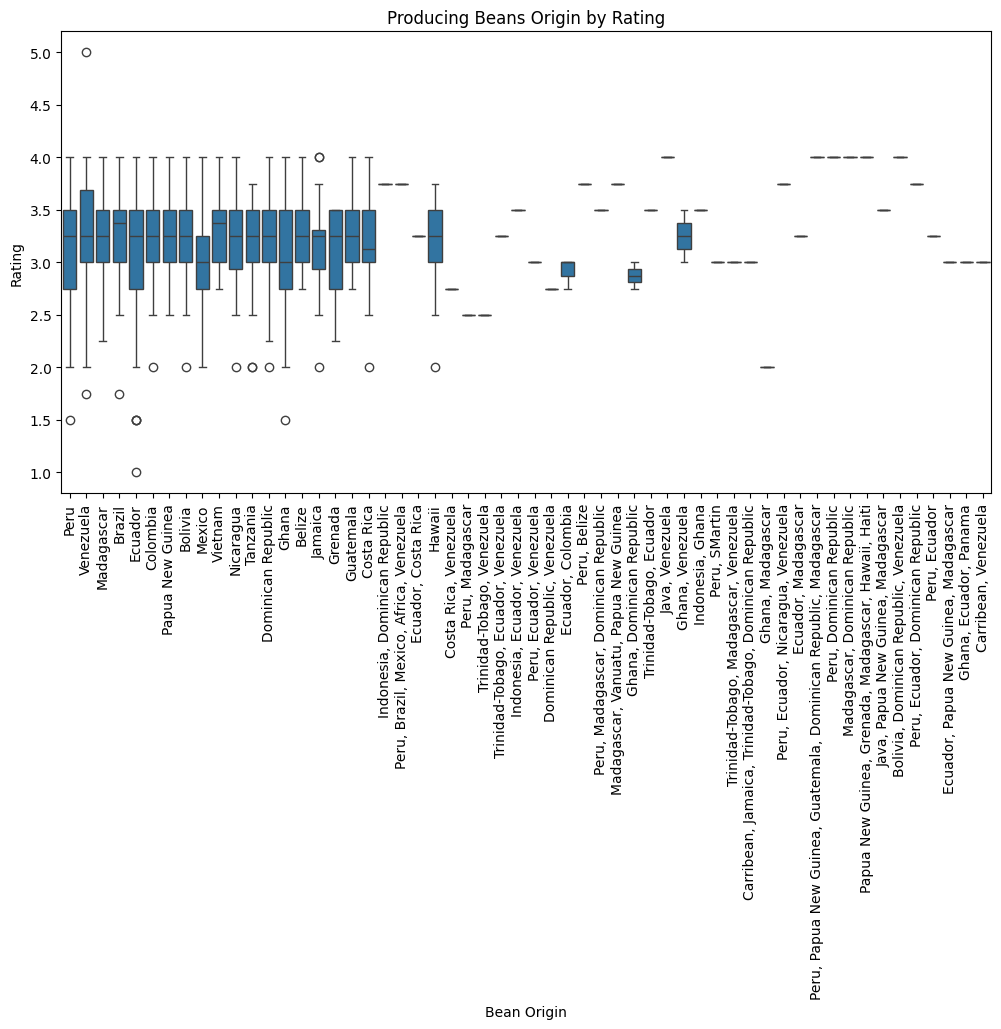

In [41]:
#The producing beans origin by rating:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_filtered['broad_origin'], y=df_filtered['rating'], data=df_filtered)
plt.xticks(rotation=90)
plt.xlabel("Bean Origin")
plt.ylabel("Rating")
plt.title("Producing Beans Origin by Rating")
plt.show()

We use boxplots to understand the rating distribution for bean origin. We overall find that the countries that produce more beans of chocolate on the world (only ones included in this plot) have high ratings between (2.5-4). The plot includes the combo/lists as well, which evidently don't have as many data points, reflected in the shape of the boxplots.

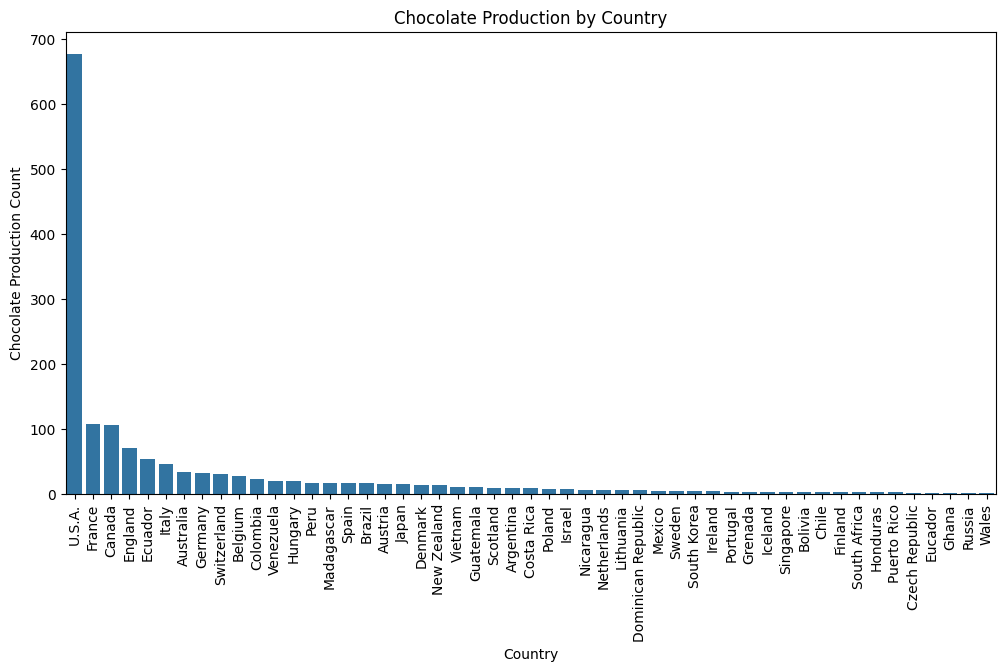

In [45]:
df_filtered2 = df_filtered.groupby('maker_location').size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.barplot(x='maker_location', y='count', data=df_filtered2, order=df_filtered2.sort_values('count', ascending=False)['maker_location'])
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Chocolate Production Count")
plt.title("Chocolate Production by Country")
plt.show()

The above plot allows us to see that the United States, France and Canada lead Chocolate production, with the U.S. with a huge lead. Even though South American countries dominated cocoa production, developed countries seem to dominate the chocolate production, meaning south american countries produce the beans for developed countries to turn into chocolate. This data can help us determine where the highest number of consumers are located, and for future studies, help us look at import and export patterns from these countries. The data also shows us that most countries have around 20 to 50 distributers, which could helps us guage the revenue of chocolate companies in each of these countries and predict whether it would be harmful or beneficials to implement more chocolate bar distributors.

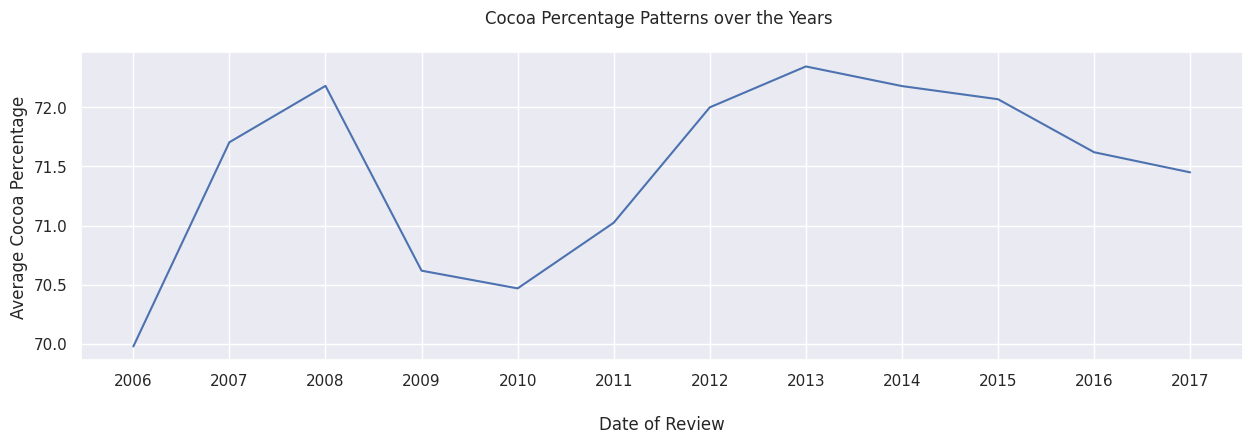

In [46]:
dcoco = df_filtered.groupby('review_date').aggregate({'cocoa_percent':'mean'})
dcoco = dcoco.reset_index()
sns.set()
plt.figure(figsize=(15, 4))
ax = sns.lineplot(x='review_date', y='cocoa_percent', data=dcoco)
ax.set(xticks=dcoco.review_date.values)
plt.xlabel("\nDate of Review")
plt.ylabel("Average Cocoa Percentage")
plt.title("Cocoa Percentage Patterns over the Years \n")
plt.show()

From this plot, we learn that the highest cocoa percentage in a chocolate bar was in 2013, with approximately 73%. The lowest percentage of cocoa was in 2006, at approximately 70%. There was a dip in cocoa percentage after a 2008 high, until 2011, when it began to rapidly increase, then steadily decrease again following 2013.

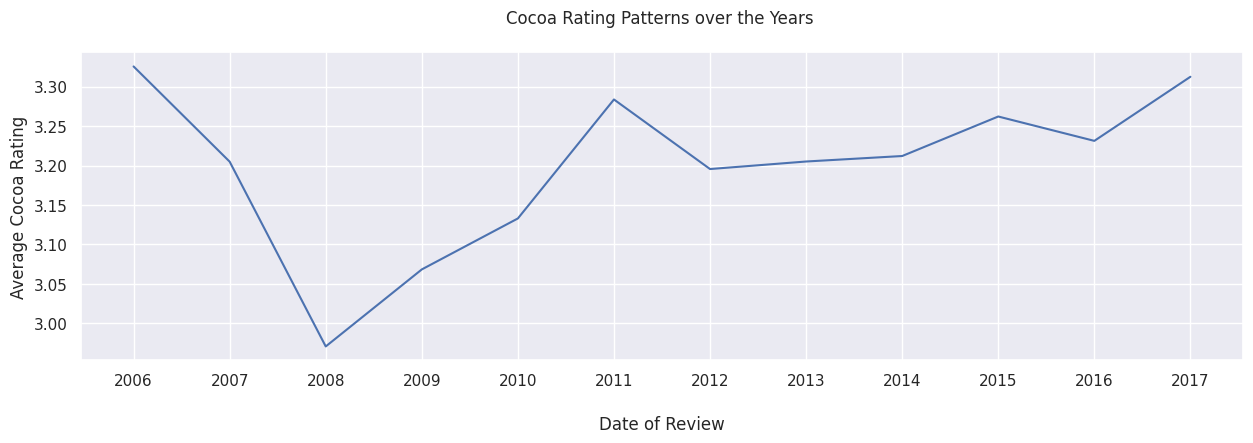

In [59]:
drate = df_filtered.groupby('review_date').aggregate({'rating':'mean'})
drate = drate.reset_index()
sns.set()
plt.figure(figsize=(15, 4))
ax = sns.lineplot(x='review_date', y='rating', data=drate)
ax.set(xticks=drate.review_date.values)
plt.xlabel("\nDate of Review")
plt.ylabel("Average Cocoa Rating")
plt.title("Cocoa Rating Patterns over the Years \n")
plt.show()

The lowest recorded rating of around 3 occurred in 2008, coinciding with one of the highest cocoa percentage in chocolate bars. From 2008 to 2011, average ratings steadily increased, reaching a bit over 3.25 in 2011. By 2017, ratings peaked at approximately 3.3. Notably, after 2011, there was a  decline in cocoa percentage alongside an increase in average rating, suggesting that chocolate producers may have reduced cocoa content to improve the taste and quality of their products.

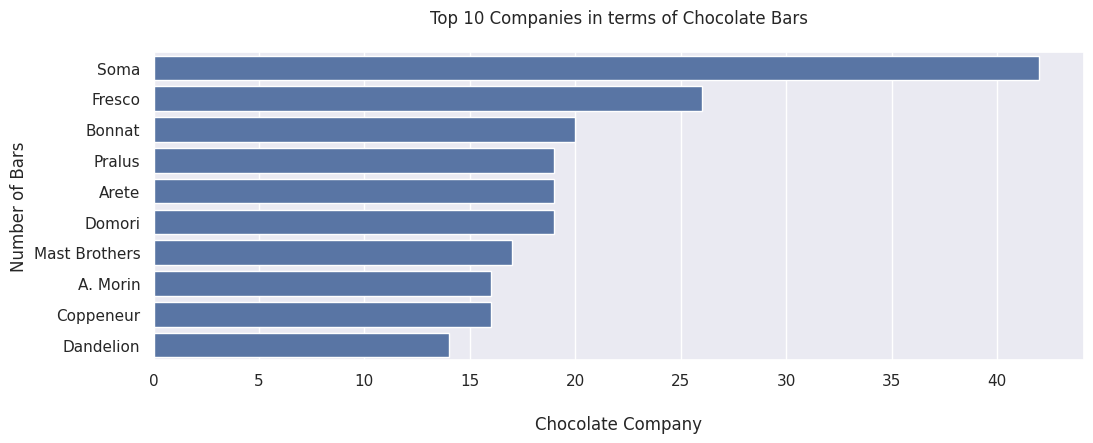

In [60]:
# Top 10 companies in terms of chocolate bars
d = df_filtered['maker'].value_counts().sort_values(ascending=False).head(10)
d = pd.DataFrame(d)
d = d.reset_index()
sns.set()
plt.figure(figsize=(12,4))
sns.barplot(x='count', y='maker', data=d)
plt.xlabel("\nChocolate Company")
plt.ylabel("Number of Bars")
plt.title("Top 10 Companies in terms of Chocolate Bars\n")
plt.show()

Soma produces the largest amount of chocolate bars by a large amount.

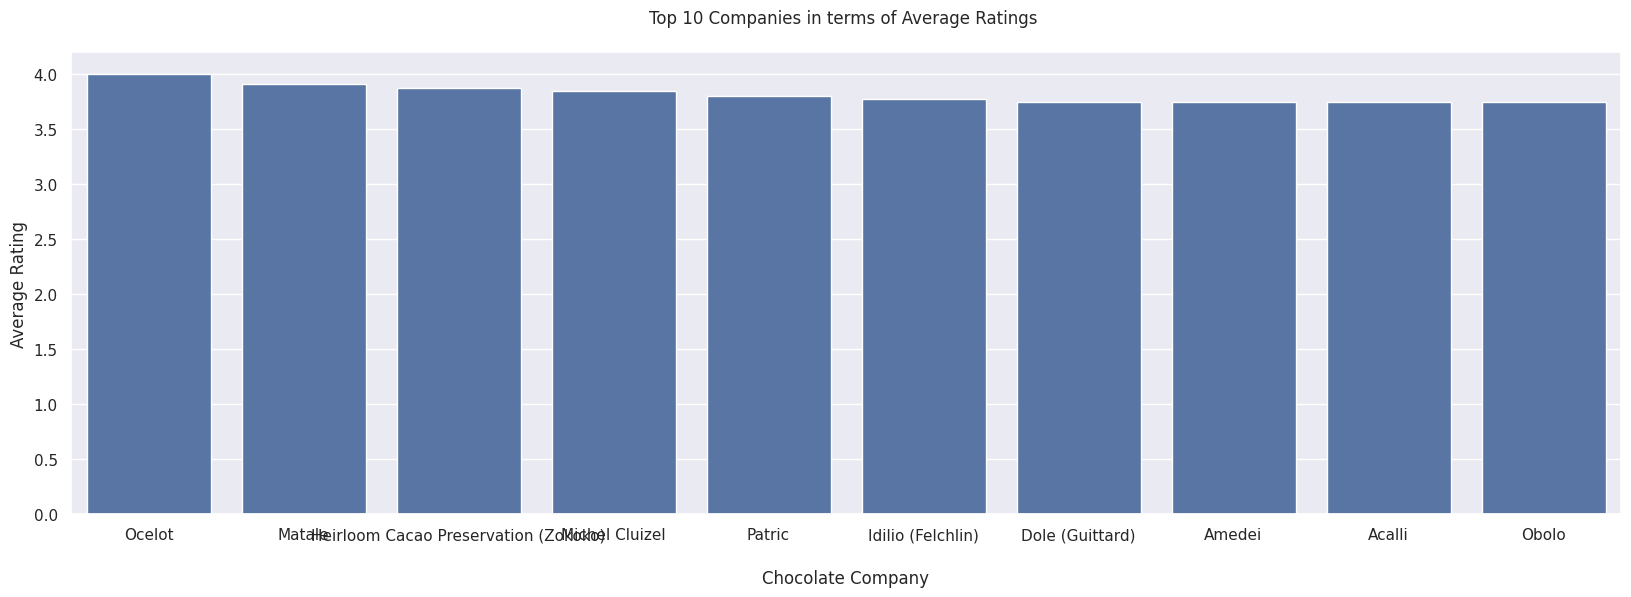

In [49]:
# Top 10 companies in terms of average ratings
d2 = df_filtered.groupby('maker').aggregate({'rating':'mean'})
d2 = d2.sort_values('rating', ascending=False).head(10)
d2 = d2.reset_index()
sns.set()
plt.figure(figsize=(20, 6))
sns.barplot(x='maker', y='rating', data=d2)
plt.xlabel("\nChocolate Company")
plt.ylabel("Average Rating")
plt.title("Top 10 Companies in terms of Average Ratings \n")
plt.show()

We learn that Soma, while producing the most chocolate, is not ranked among the top 10 highest average rated chocolate producers. Those in the top 10 have a relatively similar rating of around 4 or a little under 4.

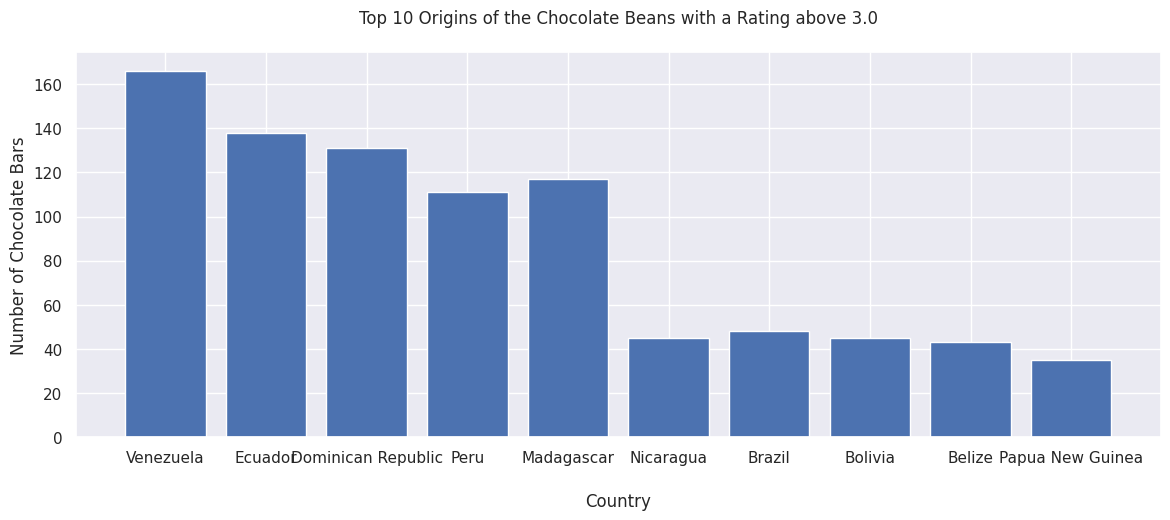

{'Venezuela': 166, 'Ecuador': 138, 'Dominican Republic': 131, 'Peru': 111, 'Madagascar': 117, 'Nicaragua': 45, 'Brazil': 48, 'Bolivia': 45, 'Belize': 43, 'Papua New Guinea': 35}


In [50]:
countries=df_filtered['broad_origin'].value_counts().index.tolist()[:10]
satisfactory={}
for j in countries:
    c=0
    b=df_filtered[df_filtered['broad_origin']==j]
    br=b[b['rating']>=3]
    for i in br['rating']:
        c+=1
        satisfactory[j]=c
li=satisfactory.keys()
plt.figure(figsize=(14,5))
plt.bar(range(len(satisfactory)), satisfactory.values(), align='center')
plt.xticks(range(len(satisfactory)), list(li))
plt.xlabel('\nCountry')
plt.ylabel('Number of Chocolate Bars')
plt.title("Top 10 Origins of the Chocolate Beans with a Rating above 3.0\n")
plt.show()
print(satisfactory)

Of the better rated chocolate bars, the vast majority of their cocoa originates from South America, and more specifically Venezuela.

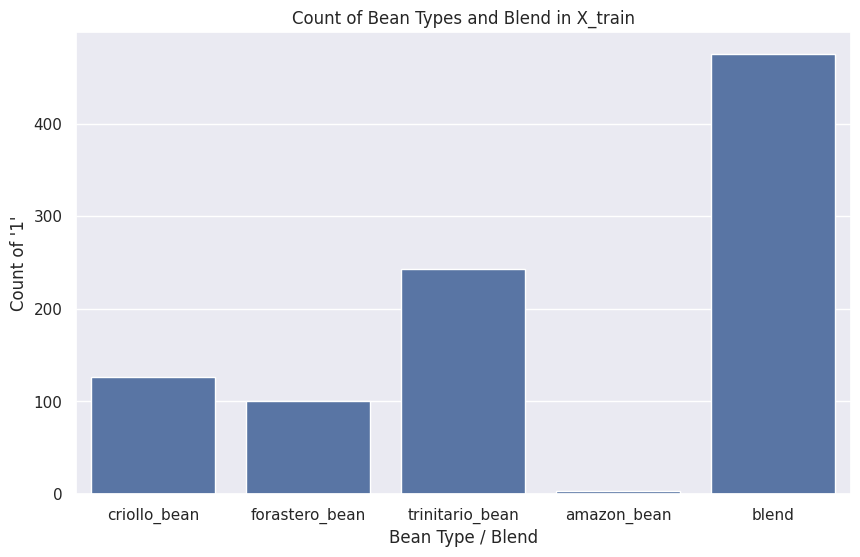

In [51]:
plt.figure(figsize=(10, 6))
bean_cols = ['criollo_bean', 'forastero_bean', 'trinitario_bean', 'amazon_bean', 'blend']
X_train_counts = X_train[bean_cols][X_train[bean_cols]==1].count()
ax = sns.barplot(x=X_train_counts.index, y=X_train_counts.values)
plt.xlabel("Bean Type / Blend")
plt.ylabel("Count of '1'")
plt.title("Count of Bean Types and Blend in X_train")
plt.show()

We see that there are barely any amazon beans, a majority of trinitario beans, and a good amount of the other two beans. The majority of the rows contain a blend of the beans.

Some overall findings that might be important for our analysis or future analysis include:


*   Chocolate with high % of cococa have a tendency to not be as delicious/highly rated
*   Better cocoa bars have a rating of 1
*   The 1 class is much higher than 0 and 2, and 0 follows a similar distribution to 1.
*   Other categorical features like maker might provide value in prediction, but we cannot one-hot encode this feature as our data would become too sparse.


---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [52]:
# YOUR CODE HERE
from sklearn.metrics import accuracy_score

# Identify the majority class in Y_train
majority_class = np.bincount(Y_train).argmax()

# Make predictions where all inputs are assigned the majority class
Y_train_pred = np.full(Y_train.shape, majority_class)
Y_val_pred = np.full(Y_val.shape, majority_class)

# Convert predictions to one-hot encoded format for softmax
num_classes = len(np.unique(Y_train))
Y_train_pred_one_hot = tf.keras.utils.to_categorical(Y_train_pred, num_classes=num_classes)
Y_val_pred_one_hot = tf.keras.utils.to_categorical(Y_val_pred, num_classes=num_classes)

# Compute accuracy for the baseline
accuracy_train = accuracy_score(Y_train, Y_train_pred)
print(f"Baseline Accuracy on Training Data: {accuracy_train:.4f}")

def softmax(z):
  """z has shape (m, n): examples, classes"""
  (m, n) = z.shape
  exps = np.exp(z)
  row_sums = np.sum(exps, axis=1)
  for i in range(m):
    exps[i,:] /= row_sums[i]
  return exps

def ce_loss(preds, Y):
  """
    preds are (m,n) m = number of examples, n = number of classes
    Y is (m,) -- array of sparse labels
    preds[0] = [.1, .1, .8] Y[0] = 2 Y_dense[0] = [0, 0, 1]
  """
  m = Y.shape[0]
  Y_dense = tf.keras.utils.to_categorical(Y)
  cross_entropy_values = - np.sum(Y_dense * np.log(preds), axis=1)
  loss = np.sum(cross_entropy_values) / m
  return loss

# Compute softmax predictions using provided softmax function in module demo 5:
W_dummy = np.ones((num_classes, X_train.shape[1]))
train_logits = np.dot(X_train, W_dummy.T)
val_logits = np.dot(X_val, W_dummy.T)
train_preds = softmax(train_logits)
val_preds = softmax(val_logits)

# Compute log loss using provided ce_loss function in module demo 5:
log_loss_train = ce_loss(train_preds, Y_train)
log_loss_val = ce_loss(val_preds, Y_val)

print(f"Log Loss on Training Data: {log_loss_train:.4f}")
print(f"Log Loss on Validation Data: {log_loss_val:.4f}")

Baseline Accuracy on Training Data: 0.7717
Log Loss on Training Data: 1.0986
Log Loss on Validation Data: 1.0986


### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.6969 - loss: 1.0982 - val_accuracy: 0.7900 - val_loss: 1.0971
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7643 - loss: 1.0968 - val_accuracy: 0.7900 - val_loss: 1.0955
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7574 - loss: 1.0954 - val_accuracy: 0.7900 - val_loss: 1.0939
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7816 - loss: 1.0936 - val_accuracy: 0.7900 - val_loss: 1.0923
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7756 - loss: 1.0922 - val_accuracy: 0.7900 - val_loss: 1.0907
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7720 - loss: 1.0906 - val_accuracy: 0.7900 - val_loss: 1.0891
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7608 - loss: 1.0894 - val_accuracy: 0.7900 - val_loss: 1.0875
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7801 - loss: 1.0875 - val_accuracy: 0.7900 - val_los

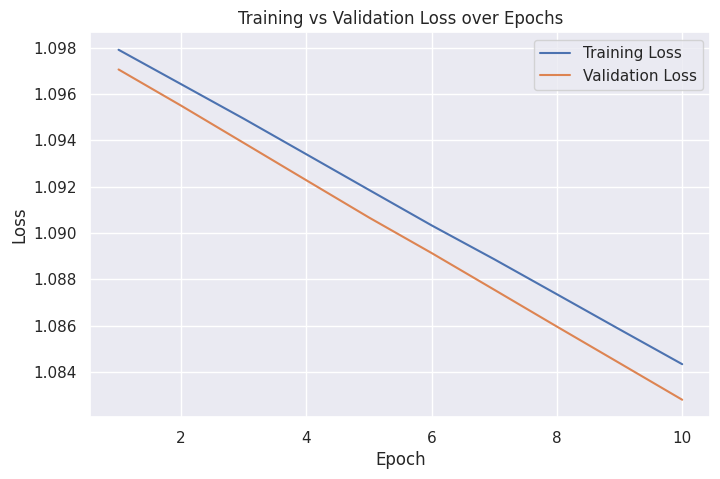

In [53]:
# YOUR CODE HERE

# Y_train and Y_val need to be integer arrays
Y_train = np.array(Y_train).astype(int)
Y_val = np.array(Y_val).astype(int)

model_tf = tf.keras.Sequential([tf.keras.layers.Dense(
    units=len(np.unique(Y_train)),
    activation="softmax",
    use_bias=True,
    input_shape=(X_train.shape[1],),
    kernel_initializer=tf.keras.initializers.Ones(),
    bias_initializer=tf.keras.initializers.Ones(),
    )
])

# Compile the model
learning_rate = 0.0001
model_tf.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Set hyperparameters
num_epochs = 10
batch_size = 32

# Train model
history = model_tf.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=1
)

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

In [54]:
# YOUR CODE HERE

# I am going with the manual approach only because I have been working on this for 16 hours and my code got deleted and lost 6 hours worth of work, including the Keras Tuner approach.
# Define different hyperparameters to test
learning_rates = [0.01, 0.05, 0.001, 0.005, 0.0001]
batch_sizes = [8, 16, 32, 64]
num_epochs_list = [10, 20, 30, 50]

best_model = None
best_val_loss = float('inf')
best_params = {}

# Try different hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in num_epochs_list:
            print(f"Training with lr={lr}, batch_size={batch_size}, epochs={num_epochs}")

            model_tf = tf.keras.Sequential([tf.keras.layers.Dense(
                units=len(np.unique(Y_train)),
                activation="softmax",
                use_bias=True,
                input_shape=(X_train.shape[1],),
                kernel_initializer=tf.keras.initializers.Ones(),
                bias_initializer=tf.keras.initializers.Ones(),
                )
            ])

            model_tf.compile(
                optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"]
            )

            history = model_tf.fit(
                X_train, Y_train,
                validation_data=(X_val, Y_val),
                epochs=num_epochs,
                batch_size=batch_size,
                verbose=0
            )

            # Get final validation loss
            final_val_loss = history.history["val_loss"][-1]

            # Track best model
            if final_val_loss < best_val_loss:
                best_val_loss = final_val_loss
                best_model = model_tf
                best_params = {
                    "learning_rate": lr,
                    "batch_size": batch_size,
                    "num_epochs": num_epochs
                }

print(f"\nBest Hyperparameters: {best_params}")

# Get the first five learned parameters (including bias)
weights, biases = best_model.layers[0].get_weights()
first_five_params = weights.flatten()[:5]
bias_term = biases[:5]
print(f"First five learned parameters: {first_five_params}")
print(f"First five bias terms: {bias_term}")

# Final loss values
final_train_loss = best_model.evaluate(X_train, Y_train, verbose=0)[0]
final_val_loss = best_model.evaluate(X_val, Y_val, verbose=0)[0]
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Compute percentage difference
percentage_diff = abs(final_train_loss - final_val_loss) / final_train_loss * 100
print(f"Percentage Difference between Training and Validation Loss: {percentage_diff:.2f}%")

# Compare with baseline loss
print(f"Baseline Training Loss: {log_loss_train:.4f}")
print(f"Baseline Validation Loss: {log_loss_val:.4f}")

train_loss_diff_percentage = ((final_train_loss - log_loss_train) / log_loss_train) * 100
val_loss_diff_percentage = ((final_val_loss - log_loss_val) / log_loss_val) * 100

print(f"Percentage Difference between Training Loss (final vs baseline): {train_loss_diff_percentage:.2f}%")
print(f"Percentage Difference between Validation Loss (final vs baseline): {val_loss_diff_percentage:.2f}%")

if final_val_loss < log_loss_val and final_train_loss <log_loss_train:
    print("The TensorFlow model demonstrates an improvement over the baseline model.")
else:
    print("The TensorFlow model does not significantly improve over the baseline.")

Training with lr=0.01, batch_size=8, epochs=10
Training with lr=0.01, batch_size=8, epochs=20
Training with lr=0.01, batch_size=8, epochs=30
Training with lr=0.01, batch_size=8, epochs=50
Training with lr=0.01, batch_size=16, epochs=10
Training with lr=0.01, batch_size=16, epochs=20
Training with lr=0.01, batch_size=16, epochs=30
Training with lr=0.01, batch_size=16, epochs=50
Training with lr=0.01, batch_size=32, epochs=10
Training with lr=0.01, batch_size=32, epochs=20
Training with lr=0.01, batch_size=32, epochs=30
Training with lr=0.01, batch_size=32, epochs=50
Training with lr=0.01, batch_size=64, epochs=10
Training with lr=0.01, batch_size=64, epochs=20
Training with lr=0.01, batch_size=64, epochs=30
Training with lr=0.01, batch_size=64, epochs=50
Training with lr=0.05, batch_size=8, epochs=10
Training with lr=0.05, batch_size=8, epochs=20
Training with lr=0.05, batch_size=8, epochs=30
Training with lr=0.05, batch_size=8, epochs=50
Training with lr=0.05, batch_size=16, epochs=10


---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [56]:
# YOUR CODE HERE

# Make predictions on train and test datasets
Y_train_probs = best_model.predict(X_train)
Y_test_probs = best_model.predict(X_test)

# Convert probabilities to class labels using argmax
Y_train_preds = np.argmax(Y_train_probs, axis=1)
Y_test_preds = np.argmax(Y_test_probs, axis=1)

# Compute per-class accuracy
unique_classes = np.unique(Y_train)
class_accuracies_train = []
class_accuracies_test = []

for cls in unique_classes:
    train_mask = (Y_train == cls)
    test_mask = (Y_test == cls)
    class_acc_train = accuracy_score(Y_train[train_mask], Y_train_preds[train_mask])
    class_acc_test = accuracy_score(Y_test[test_mask], Y_test_preds[test_mask])
    class_accuracies_train.append(class_acc_train)
    class_accuracies_test.append(class_acc_test)

# Compute aggregate accuracy as the mean per-class accuracy
aggregate_accuracy_train = np.mean(class_accuracies_train)
aggregate_accuracy_test = np.mean(class_accuracies_test)

print(f"Aggregate Accuracy on Training Data: {aggregate_accuracy_train:.4f}")
print(f"Aggregate Accuracy on Test Data: {aggregate_accuracy_test:.4f}")

# Compute the percentage difference between train and test aggregate accuracy
accuracy_diff = abs(aggregate_accuracy_train - aggregate_accuracy_test) / aggregate_accuracy_train * 100
print(f"Percentage Difference between Train and Test Aggregate Accuracy: {accuracy_diff:.2f}%")
print("Since train and test aggregate accuracy have a small difference (0), the model generalized well.")
print("However, the poor aggregate accuracy score indicates the model performs poorly in distinguishing between our 3 groups of cocoa percentage")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Aggregate Accuracy on Training Data: 0.3333
Aggregate Accuracy on Test Data: 0.3333
Percentage Difference between Train and Test Aggregate Accuracy: 0.00%
Since train and test aggregate accuracy have a small difference (0), the model generalized well.
However, the poor aggregate accuracy score indicates the model performs poorly in distinguishing between our 3 groups of cocoa percentage


### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

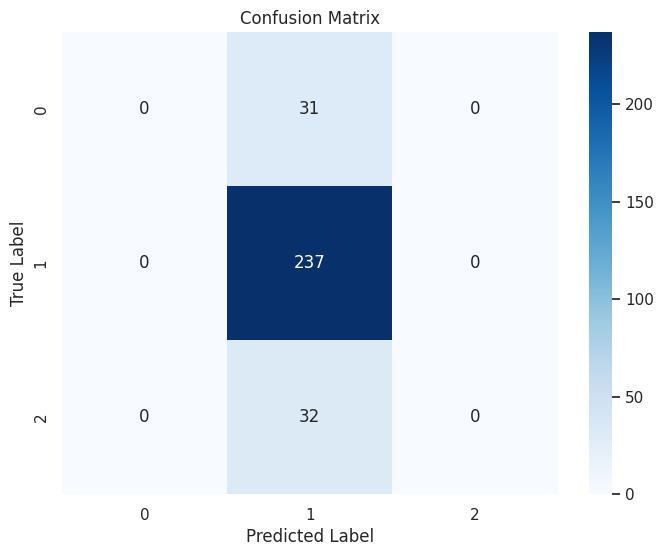

The model confuses class 1 the most with class 2.
Class 0 has the lowest precision: 0.0000
Class 1 is the largest source of false positives.
Class 0 has the lowest recall: 0.0000
Class 2 is the largest source of false negatives.


In [57]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Compute the most confused class (highest non-diagonal value)
conf_matrix_copy = conf_matrix.copy()
np.fill_diagonal(conf_matrix_copy, 0)
most_confused_class = np.unravel_index(np.argmax(conf_matrix_copy), conf_matrix_copy.shape)
print(f"The model confuses class {most_confused_class[1]} the most with class {most_confused_class[0]}.")

# Compute per-class precision and recall
precision = precision_score(Y_test, Y_test_preds, average=None)
recall = recall_score(Y_test, Y_test_preds, average=None)

# Compute the class with the lowest precision
lowest_precision_class = np.argmin(precision)
print(f"Class {lowest_precision_class} has the lowest precision: {precision[lowest_precision_class]:.4f}")

# Compute the class with the most false positives
false_positives = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
largest_fp_class = np.argmax(false_positives)
print(f"Class {largest_fp_class} is the largest source of false positives.")

# Compute the class with the lowest recall
lowest_recall_class = np.argmin(recall)
print(f"Class {lowest_recall_class} has the lowest recall: {recall[lowest_recall_class]:.4f}")

# 9: Compute the class with the most false negatives
false_negatives = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
largest_fn_class = np.argmax(false_negatives)
print(f"Class {largest_fn_class} is the largest source of false negatives.")


All labels are predicted as 1, meaning are model is not doing well at predicting/distinguishing class labels.

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [58]:
# YOUR CODE HERE
print("Our model is evidently showing signs of unfairness as all class lables are 1, and there was huge class imbalance from the start. To rectify this, we can either upsample class 0 and 2 or downsample class 1 using SMOTE.")

Our model is evidently showing signs of unfairness as all class lables are 1, and there was huge class imbalance from the start. To rectify this, we can either upsample class 0 and 2 or downsample class 1 using SMOTE.
